In [140]:
import pandas as pd
import numpy as np

import re

from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium

from shapely.geometry import polygon, multipolygon, Point

import mapclassify as mc
import libpysal as lp

import esda # Morans
from esda.getisord import G, G_Local

from scipy.stats import boxcox

from foursquare import fetch_venue_categories, fetch_venue_likes

# Local Moran's I - venue density (count and weighted)

## Load District boundaries

In [80]:
districts_gdf = gpd.read_file('data/Bangkok_neighbourhoods.json')
# Preserve id for dissolve bounds operation below
districts_gdf = districts_gdf[['NAME_0', 'NAME_2', 'geometry']]
districts_gdf.columns = ['subject','district','geometry']
districts_gdf

subject            district  \
0   Thailand              Ban Na   
1   Thailand           Ongkharak   
2   Thailand            Bang Len   
3   Thailand    Phuttha Mon Thon   
4   Thailand             Bang Su   
..       ...                 ...   
80  Thailand             Bang Bo   
81  Thailand    Phra Samut Jadee   
82  Thailand        Krathum Baen   
83  Thailand  Muang Samut Sakhon   
84  Thailand         Wihan Daeng   

                                             geometry  
0   MULTIPOLYGON (((101.06481 14.41179, 101.06536 ...  
1   MULTIPOLYGON (((100.97552 14.23500, 100.97700 ...  
2   MULTIPOLYGON (((100.28336 14.14591, 100.28307 ...  
3   MULTIPOLYGON (((100.32971 13.80120, 100.33000 ...  
4   MULTIPOLYGON (((100.53735 13.83085, 100.53590 ...  
..                                                ...  
80  MULTIPOLYGON (((100.93635 13.66819, 100.93792 ...  
81  MULTIPOLYGON (((100.55722 13.61222, 100.55778 ...  
82  MULTIPOLYGON (((100.33558 13.72002, 100.33561 ...  
83  MULTIPOLYGON (((100.34015 13.64018, 100.34168 ...  
84  MULTIPOLYGON (((100.99131 14.42083, 100.99177 ...  

[85 rows x 3 columns]

## Load Food Venues

In [2]:
venues_gdf = gpd.read_file('data/Bangkok_districts_food_venues.geojson',index_col=0)
venues_gdf

city                        id  \
0      Bangkok  5d89ecb2ebc5f800083c9c72   
1      Bangkok  4f979611e4b0107577b7473d   
2      Bangkok  4f019036c5126f14b907d325   
3      Bangkok  4f2a1166e4b0d4e47d2b0990   
4      Bangkok  4ee0b7b80e01452f928d12ee   
...        ...                       ...   
56384  Bangkok  4e5a1b4c52b1b78b81a5ab1d   
56385  Bangkok  4feab941e4b07f87a595eb68   
56386  Bangkok  4fbdc0d8e4b06a0de5ba961b   
56387  Bangkok  5683b4e2498e95633f18c3bf   
56388  Bangkok  4dfcedb5d22d879302f709d3   

                                                    name            category  \
0      วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...          Restaurant   
1                                      น้ำดื่มไลออนคิงส์       Deli / Bodega   
2                                             ครัวแสงดาว  Seafood Restaurant   
3                อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก          Restaurant   
4             ลาบยโส ด่านช่างพระราม2 บางโทรัด  สมุทรสาคร     Thai Restaurant   
...                                                  ...                 ...   
56384                          เรือนรับรองโรงเรียนเตรียม     Thai Restaurant   
56385                                    ร้านกาแฟพี่กุ้ง         Coffee Shop   
56386                   ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร        Noodle House   
56387                         Wine I Love You Sweet Cafe          Donut Shop   
56388                                    ข้าวต้มอ๊อดอ๊อด                Food   

                         geometry  
0      POINT (100.08018 13.42733)  
1      POINT (100.07984 13.42660)  
2      POINT (100.09205 13.43016)  
3      POINT (100.07888 13.44924)  
4      POINT (100.07936 13.44986)  
...                           ...  
56384  POINT (101.12332 14.30844)  
56385  POINT (101.11967 14.30635)  
56386  POINT (101.12011 14.30625)  
56387  POINT (101.11607 14.30994)  
56388  POINT (101.21884 13.58082)  

[56389 rows x 5 columns]

In [49]:
for i,v in venues_gdf[34942:34943].iterrows():
    venues_gdf.loc[i,'likes']=fetch_venue_likes(v.id)

Status 404


In [53]:
# Drop three venues for which likes unfound
missing_likes = venues_gdf[venues_gdf.likes.isna()].index
venues_gdf.drop(missing_likes,inplace=True)

In [307]:
# venues_gdf.to_file('data/Bangkok_venues_likes.geojson', driver='GeoJSON')
venues_gdf[['id','geometry','likes']].to_file('data/Bangkok_venue_likes.shp')

In [58]:
venues_gdf.likes.sort_values(ascending=False)

19721    1216.0
45572    1108.0
19722     870.0
25892     779.0
18718     742.0
          ...  
34151       0.0
34150       0.0
42696      -1.0
9877       -1.0
27269      -1.0
Name: likes, Length: 56386, dtype: float64

In [138]:
(venues_gdf.likes==0).sum()

35816

In [62]:
venues_gdf.drop(venues_gdf[venues_gdf.likes<0].index,inplace=True)

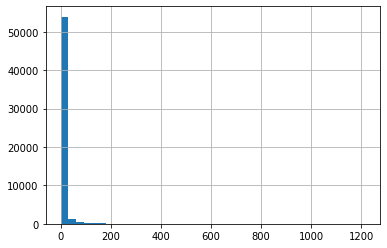

In [132]:
venues_gdf.likes.hist(bins=40)

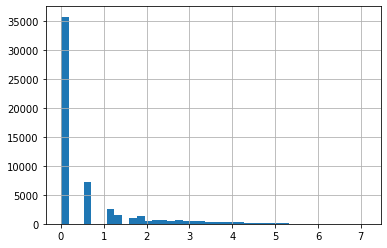

In [135]:
# Take log of 'likes' since its distribution is 0-skewed
venues_gdf['log_likes']=np.log(venues_gdf.likes+1) # correct for many zeros - or try boxcox
venues_gdf.log_likes.hist(bins=40)

In [153]:
bc = boxcox(venues_gdf.likes+1)

print('boxcox lambda:', bc[1])
venues_gdf['boxcox_likes'] = bc[0]

boxcox lambda: -1.1225846908253287


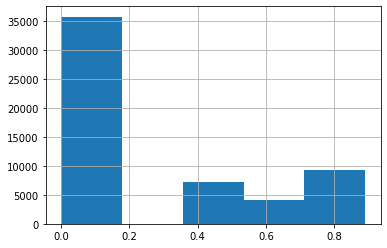

In [148]:
venues_gdf.boxcox_likes.hist(bins=5)

In [160]:
# Since it is unlikely that greater than half of food venues provide zero value,
# convert boxcox_likes to ordinal values
venue_values=["zero","low","medium","high","highest"]
venues_gdf['venue_value'] = pd.cut(venues_gdf.boxcox_likes, 5, labels=venue_values)
venues_gdf

city                        id  \
0      Bangkok  5d89ecb2ebc5f800083c9c72   
1      Bangkok  4f979611e4b0107577b7473d   
2      Bangkok  4f019036c5126f14b907d325   
3      Bangkok  4f2a1166e4b0d4e47d2b0990   
4      Bangkok  4ee0b7b80e01452f928d12ee   
...        ...                       ...   
56384  Bangkok  4e5a1b4c52b1b78b81a5ab1d   
56385  Bangkok  4feab941e4b07f87a595eb68   
56386  Bangkok  4fbdc0d8e4b06a0de5ba961b   
56387  Bangkok  5683b4e2498e95633f18c3bf   
56388  Bangkok  4dfcedb5d22d879302f709d3   

                                                    name            category  \
0      วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...          Restaurant   
1                                      น้ำดื่มไลออนคิงส์       Deli / Bodega   
2                                             ครัวแสงดาว  Seafood Restaurant   
3                อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก          Restaurant   
4             ลาบยโส ด่านช่างพระราม2 บางโทรัด  สมุทรสาคร     Thai Restaurant   
...                                                  ...                 ...   
56384                          เรือนรับรองโรงเรียนเตรียม     Thai Restaurant   
56385                                    ร้านกาแฟพี่กุ้ง         Coffee Shop   
56386                   ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร        Noodle House   
56387                         Wine I Love You Sweet Cafe          Donut Shop   
56388                                    ข้าวต้มอ๊อดอ๊อด                Food   

                         geometry  likes  log_likes  boxcox_likes venue_value  
0      POINT (100.08018 13.42733)    0.0   0.000000      0.000000        zero  
1      POINT (100.07984 13.42660)    0.0   0.000000      0.000000        zero  
2      POINT (100.09205 13.43016)    0.0   0.000000      0.000000        zero  
3      POINT (100.07888 13.44924)    0.0   0.000000      0.000000        zero  
4      POINT (100.07936 13.44986)    0.0   0.000000      0.000000        zero  
...                           ...    ...        ...           ...         ...  
56384  POINT (101.12332 14.30844)    2.0   1.098612      0.631281        high  
56385  POINT (101.11967 14.30635)    0.0   0.000000      0.000000        zero  
56386  POINT (101.12011 14.30625)    0.0   0.000000      0.000000        zero  
56387  POINT (101.11607 14.30994)    0.0   0.000000      0.000000        zero  
56388  POINT (101.21884 13.58082)    0.0   0.000000      0.000000        zero  

[56383 rows x 9 columns]

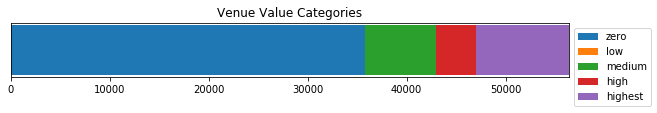

In [235]:
N = len(venues_gdf)
height = 0.02  # the width of the bars: can also be len(x) sequence
counts = venues_gdf.venue_value.value_counts()

zero_count = counts[venue_values[0]]
low_count = counts[venue_values[1]]
med_count = counts[venue_values[2]]
high_count = counts[venue_values[3]]
highest_count = counts[venue_values[4]]

fig = plt.figure(figsize=(10,1))
ax = plt.subplot(111)

bar_zero = ax.barh(0, zero_count, height)
bar_low = ax.barh(0, low_count, height, left=zero_count)
bar_med = ax.barh(0, med_count, height, left=low_count+zero_count)
bar_high = ax.barh(0, high_count, height, left=med_count+low_count+zero_count)
bar_highest = ax.barh(0, highest_count, height, left=high_count+med_count+low_count+zero_count)

ax.set_title('Venue Value Categories')
# plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
ax.set_xlim(0,N)
ax.set_yticks([])
ax.legend((bar_zero[0], bar_low[0], bar_med[0], bar_high[0], bar_highest[0]),\
           tuple(venue_values), loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [264]:
print("zero category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='zero'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='zero'].likes.max()))
print("low category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='low'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='low'].likes.max()))
print("medium category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='medium'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='medium'].likes.max()))
print("high category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='high'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='high'].likes.max()))
print("higheset category range: {} - {}".format(
    venues_gdf[venues_gdf.venue_value=='highest'].likes.min(),
    venues_gdf[venues_gdf.venue_value=='highest'].likes.max()))

zero category range: 0.0 - 0.0
low category range: nan - nan
medium category range: 1.0 - 1.0
high category range: 2.0 - 3.0
higheset category range: 4.0 - 1216.0


In [271]:
venues_gdf[venues_gdf.venue_value=='low'].count()

city            0
id              0
name            0
category        0
geometry        0
likes           0
log_likes       0
boxcox_likes    0
venue_value     0
dtype: int64

In [278]:
# After log transform, secondary category drops out with no members
# This also helps us maintain interpretability

venue_value_weights = {
    'zero': 0.25,
    'low': 0, # we expect none
    'medium': 0.5,
    'high': 0.75,
    'highest': 1
}

venues_gdf['venue_value_weight'] = venues_gdf.venue_value.apply(lambda x: venue_value_weights[x])
venues_gdf

city                        id  \
0      Bangkok  5d89ecb2ebc5f800083c9c72   
1      Bangkok  4f979611e4b0107577b7473d   
2      Bangkok  4f019036c5126f14b907d325   
3      Bangkok  4f2a1166e4b0d4e47d2b0990   
4      Bangkok  4ee0b7b80e01452f928d12ee   
...        ...                       ...   
56384  Bangkok  4e5a1b4c52b1b78b81a5ab1d   
56385  Bangkok  4feab941e4b07f87a595eb68   
56386  Bangkok  4fbdc0d8e4b06a0de5ba961b   
56387  Bangkok  5683b4e2498e95633f18c3bf   
56388  Bangkok  4dfcedb5d22d879302f709d3   

                                                    name            category  \
0      วนิดาฟาร์ม ร้านอาหารทะเล ฟาร์มสเตย์ และบ่อตกปล...          Restaurant   
1                                      น้ำดื่มไลออนคิงส์       Deli / Bodega   
2                                             ครัวแสงดาว  Seafood Restaurant   
3                อังเคิ้ลอาหารตามสั่ง ในปั้มน้ำมันบางจาก          Restaurant   
4             ลาบยโส ด่านช่างพระราม2 บางโทรัด  สมุทรสาคร     Thai Restaurant   
...                                                  ...                 ...   
56384                          เรือนรับรองโรงเรียนเตรียม     Thai Restaurant   
56385                                    ร้านกาแฟพี่กุ้ง         Coffee Shop   
56386                   ก๋วยเตี๋ยวห้อยขา @ รร.เตรียมทหาร        Noodle House   
56387                         Wine I Love You Sweet Cafe          Donut Shop   
56388                                    ข้าวต้มอ๊อดอ๊อด                Food   

                         geometry  likes  log_likes  boxcox_likes venue_value  \
0      POINT (100.08018 13.42733)    0.0   0.000000      0.000000        zero   
1      POINT (100.07984 13.42660)    0.0   0.000000      0.000000        zero   
2      POINT (100.09205 13.43016)    0.0   0.000000      0.000000        zero   
3      POINT (100.07888 13.44924)    0.0   0.000000      0.000000        zero   
4      POINT (100.07936 13.44986)    0.0   0.000000      0.000000        zero   
...                           ...    ...        ...           ...         ...   
56384  POINT (101.12332 14.30844)    2.0   1.098612      0.631281        high   
56385  POINT (101.11967 14.30635)    0.0   0.000000      0.000000        zero   
56386  POINT (101.12011 14.30625)    0.0   0.000000      0.000000        zero   
56387  POINT (101.11607 14.30994)    0.0   0.000000      0.000000        zero   
56388  POINT (101.21884 13.58082)    0.0   0.000000      0.000000        zero   

      venue_value_weight  
0                   0.25  
1                   0.25  
2                   0.25  
3                   0.25  
4                   0.25  
...                  ...  
56384               0.75  
56385               0.25  
56386               0.25  
56387               0.25  
56388               0.25  

[56383 rows x 10 columns]

In [281]:
venues_gdf.venue_value_weight = venues_gdf.venue_value_weight.astype(float)
venues_gdf.venue_value_weight.dtype

dtype('float64')

In [302]:
venues_gdf[['id', 'category', 'geometry', 'likes', 'venue_value_weight']].to_file('data/Bangkok_venue_values.geojson', driver='GeoJSON')

In [67]:
city_neighborhoods_gdf = gpd.read_file('data/Bangkok_neighbourhoods.json')
city_neighborhoods_gdf = city_neighborhoods_gdf[['NAME_2', 'geometry']]
city_neighborhoods_gdf.columns = ['district', 'geometry']
city_neighborhoods_gdf

district                                           geometry
0               Ban Na  MULTIPOLYGON (((101.06481 14.41179, 101.06536 ...
1            Ongkharak  MULTIPOLYGON (((100.97552 14.23500, 100.97700 ...
2             Bang Len  MULTIPOLYGON (((100.28336 14.14591, 100.28307 ...
3     Phuttha Mon Thon  MULTIPOLYGON (((100.32971 13.80120, 100.33000 ...
4              Bang Su  MULTIPOLYGON (((100.53735 13.83085, 100.53590 ...
..                 ...                                                ...
80             Bang Bo  MULTIPOLYGON (((100.93635 13.66819, 100.93792 ...
81    Phra Samut Jadee  MULTIPOLYGON (((100.55722 13.61222, 100.55778 ...
82        Krathum Baen  MULTIPOLYGON (((100.33558 13.72002, 100.33561 ...
83  Muang Samut Sakhon  MULTIPOLYGON (((100.34015 13.64018, 100.34168 ...
84         Wihan Daeng  MULTIPOLYGON (((100.99131 14.42083, 100.99177 ...

[85 rows x 2 columns]

In [68]:
venue_density_df =\
    gpd.sjoin(venues_gdf,city_neighborhoods_gdf,how='right',op='within')\
        .groupby('district')\
        .agg({'geometry': 'first', 'id': 'count'})

venue_density_df =\
    gpd.GeoDataFrame(venue_density_df, crs={'init': 'epsg:4326'})

venue_density_df['area_sqkm'] =\
    venue_density_df.apply(lambda n: n.geometry.area/10**6, axis=1)
venue_density_df['density'] =\
    venue_density_df['id']/venue_density_df['area_sqkm']

venue_density_df.reset_index(inplace=True)
venue_density_df

district                                           geometry    id  \
0           Ban Na  MULTIPOLYGON (((101.06481 14.41179, 101.06536 ...   299   
1          Ban Pho  MULTIPOLYGON (((100.96163 13.70401, 100.96242 ...   282   
2          Bang Bo  MULTIPOLYGON (((100.93635 13.66819, 100.93792 ...   307   
3         Bang Bon  MULTIPOLYGON (((100.43022 13.67181, 100.42820 ...   104   
4   Bang Bua Thong  MULTIPOLYGON (((100.38375 13.98669, 100.38609 ...  1094   
..             ...                                                ...   ...   
80        Wang Noi  MULTIPOLYGON (((100.82285 14.32829, 100.82439 ...   313   
81  Wang Thonglang  MULTIPOLYGON (((100.58796 13.80530, 100.58826 ...   604   
82         Wattana  MULTIPOLYGON (((100.55692 13.75175, 100.55806 ...  1704   
83     Wihan Daeng  MULTIPOLYGON (((100.99131 14.42083, 100.99177 ...   105   
84         Yannawa  MULTIPOLYGON (((100.54800 13.72229, 100.55074 ...  1307   

       area_sqkm       density  
0   2.951617e-08  1.013004e+10  
1   1.733921e-08  1.626371e+10  
2   1.827028e-08  1.680324e+10  
3   3.017369e-09  3.446712e+10  
4   1.106805e-08  9.884306e+10  
..           ...           ...  
80  1.942248e-08  1.611535e+10  
81  1.434320e-09  4.211054e+11  
82  1.073738e-09  1.586980e+12  
83  1.910760e-08  5.495196e+09  
84  1.233046e-09  1.059976e+12  

[85 rows x 5 columns]

In [282]:
weighted_density_df =\
    gpd.sjoin(venues_gdf,city_neighborhoods_gdf,how='right',op='within')\
        .groupby('district')\
        .agg({'geometry': 'first', 'venue_value_weight': 'sum'})

weighted_density_gdf =\
    gpd.GeoDataFrame(weighted_density_df, crs={'init': 'epsg:4326'})

weighted_density_gdf['area_sqkm'] =\
    weighted_density_gdf.apply(lambda n: n.geometry.area/10**6, axis=1)
weighted_density_gdf['density'] =\
    weighted_density_gdf['venue_value_weight']/weighted_density_gdf['area_sqkm']

weighted_density_gdf.reset_index(inplace=True)
weighted_density_gdf.head()

district                                           geometry  \
0          Ban Na  MULTIPOLYGON (((101.06481 14.41179, 101.06536 ...   
1         Ban Pho  MULTIPOLYGON (((100.96163 13.70401, 100.96242 ...   
2         Bang Bo  MULTIPOLYGON (((100.93635 13.66819, 100.93792 ...   
3        Bang Bon  MULTIPOLYGON (((100.43022 13.67181, 100.42820 ...   
4  Bang Bua Thong  MULTIPOLYGON (((100.38375 13.98669, 100.38609 ...   

   venue_value_weight     area_sqkm       density  
0              108.50  2.951617e-08  3.675951e+09  
1              107.00  1.733921e-08  6.170984e+09  
2              116.50  1.827028e-08  6.376475e+09  
3               65.75  3.017369e-09  2.179051e+10  
4              451.50  1.106805e-08  4.079309e+10

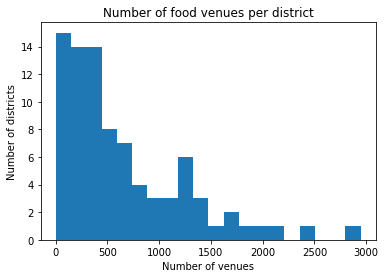

In [70]:
venue_density_df.id.plot(kind='hist', bins=20)
plt.title('Number of food venues per district')
plt.xlabel('Number of venues')
plt.ylabel('Number of districts')
plt.show()

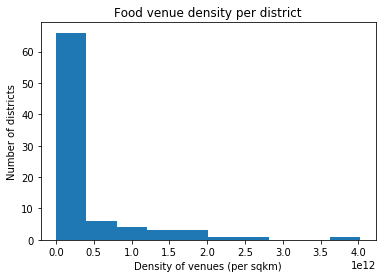

In [71]:
venue_density_df.density.plot(kind='hist')
plt.title('Food venue density per district')
plt.xlabel('Density of venues (per sqkm)')
plt.ylabel('Number of districts')
plt.show()

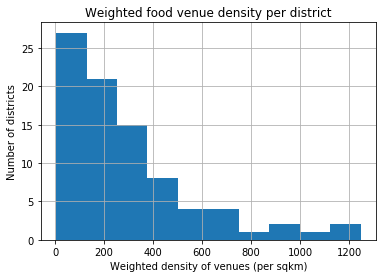

In [284]:
weighted_density_gdf.venue_value_weight.hist()
plt.title('Weighted food venue density per district')
plt.xlabel('Weighted density of venues (per sqkm)')
plt.ylabel('Number of districts')
plt.show()

In [117]:
saturated_neigh_df = venue_density_df[venue_density_df.id > 0]
len(saturated_neigh_df)

85

In [83]:
loc = districts_gdf.dissolve(by='subject').centroid

city_map = folium.Map(
    location=(loc.y,loc.x),
    zoom_start=10,
    tiles='cartodbpositron' #'Stamen Toner'
)

folium.Choropleth(
    geo_data=city_neighborhoods_gdf,
    name='choropleth',
    data=saturated_neigh_df,
    columns=['district','density'],
    key_on='feature.properties.district',
    fill_color='Purples',
    bins=5,
    legend_name='Food Venues (per sqkm)'
).add_to(city_map)

city_map

In [89]:
city_map = folium.Map(
    location=(loc.y,loc.x),
    zoom_start=10,
    tiles='cartodbpositron' #'Stamen Toner'
)

folium.Choropleth(
    geo_data=city_neighborhoods_gdf,
    name='choropleth',
    data=venue_density_df,
    columns=['district','density'],
    key_on='feature.properties.district',
    fill_color='Purples',
    bins=5,
    legend_name='Food Venues (per sqkm)'
).add_to(city_map)

city_map

In [285]:
city_map = folium.Map(
    location=(loc.y,loc.x),
    zoom_start=10,
    tiles='cartodbpositron' #'Stamen Toner'
)

folium.Choropleth(
    geo_data=city_neighborhoods_gdf,
    name='choropleth',
    data=weighted_density_gdf,
    columns=['district','density'],
    key_on='feature.properties.district',
    fill_color='Purples',
    bins=5,
    legend_name='Food Venues (per sqkm)'
).add_to(city_map)

city_map

## Unweighted Global Morans

In [91]:
# Global autocorrelation test - is the distribution of food venues random?

wq =  lp.weights.Queen.from_dataframe(venue_density_df)
wq.transform = 'r'

In [92]:
# Compute spatial lag - the weighted average of food venue density per neighborhood

y = venue_density_df['density']
ylag = lp.weights.lag_spatial(wq, y)
ylag[0:5]

array([5.59416238e+09, 2.90737055e+10, 5.28913752e+10, 8.65368400e+10,
       1.15686964e+11])

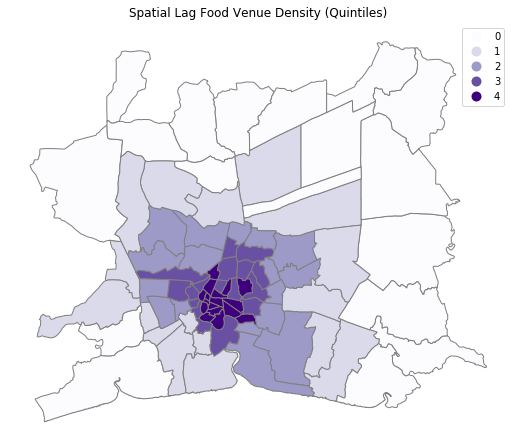

In [127]:
# Plot Food venue density quintiles and spatial lag
ylagq5 = mc.Quantiles(ylag, k=5)

venue_density_df['cl']=pd.Series(ylagq5.yb).astype('category')

f, ax = plt.subplots(1, figsize=(9, 9))
venue_density_df.plot(column='cl', categorical=True, k=5, \
        cmap='Purples', ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Food Venue Density (Quintiles)")

plt.show()

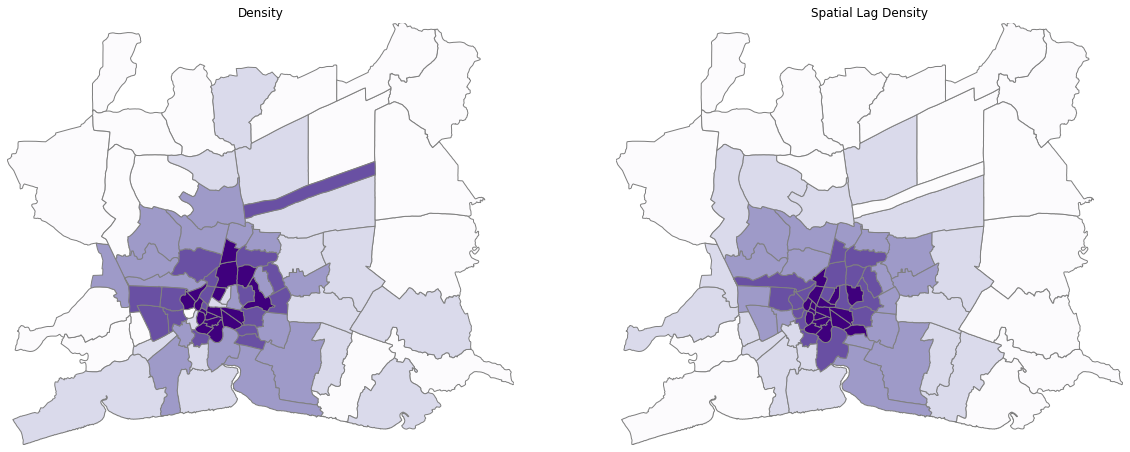

In [125]:
venue_density_df['lag_density'] = ylag #make this _gdf
f,ax = plt.subplots(1,2,figsize=(20,10))

venue_density_df.plot(column='density', ax=ax[0], edgecolor='grey',
        scheme="quantiles",  k=5, cmap='Purples')
ax[0].axis(venue_density_df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Density")

venue_density_df.plot(column='lag_density', ax=ax[1], edgecolor='grey',
        scheme='quantiles', cmap='Purples', k=5)
ax[1].axis(venue_density_df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Density")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

Text(0.5, 0, "Moran's I")

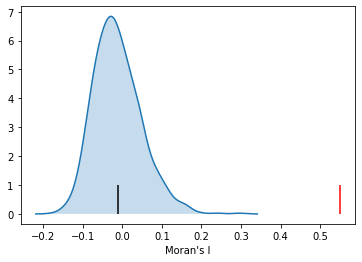

In [96]:
np.random.seed(123)
mi = esda.moran.Moran(y, wq)

sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [97]:
# A p-value of 0.05 and less is significant
mi.p_sim # compared to value of ___ previously recorded for 3/8 of the districts

0.001

In [245]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.

## Weighted Global Morans

In [286]:
# Global autocorrelation test - is the distribution of food venues random?

weighted_wq = lp.weights.Queen.from_dataframe(weighted_density_gdf)

# Moran’s I is more commonly defined in terms of local averages, not local sums. 
# Therefore, let’s use row standardization so that our spatial lag is a local average
weighted_wq.transform = 'r'

In [287]:
# Compute spatial lag - the weighted average of food venue density per neighborhood

weighted_y = weighted_density_gdf['density']
weighted_ylag = lp.weights.lag_spatial(weighted_wq, weighted_y)
weighted_ylag[0:5]

array([1.90955051e+09, 1.11506003e+10, 2.08727775e+10, 3.79571746e+10,
       4.78922163e+10])

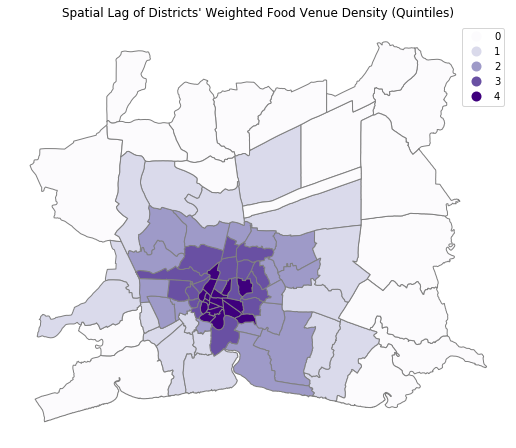

In [288]:
# Plot Food venue density quintiles and spatial lag
weighted_ylagq5 = mc.Quantiles(weighted_ylag, k=5)

weighted_density_gdf['cl']=pd.Series(weighted_ylagq5.yb).astype('category')

f, ax = plt.subplots(1, figsize=(9, 9))
weighted_density_gdf.plot(column='cl', categorical=True, k=5, \
        cmap='Purples', ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag of Districts' Weighted Food Venue Density (Quintiles)")

plt.show()

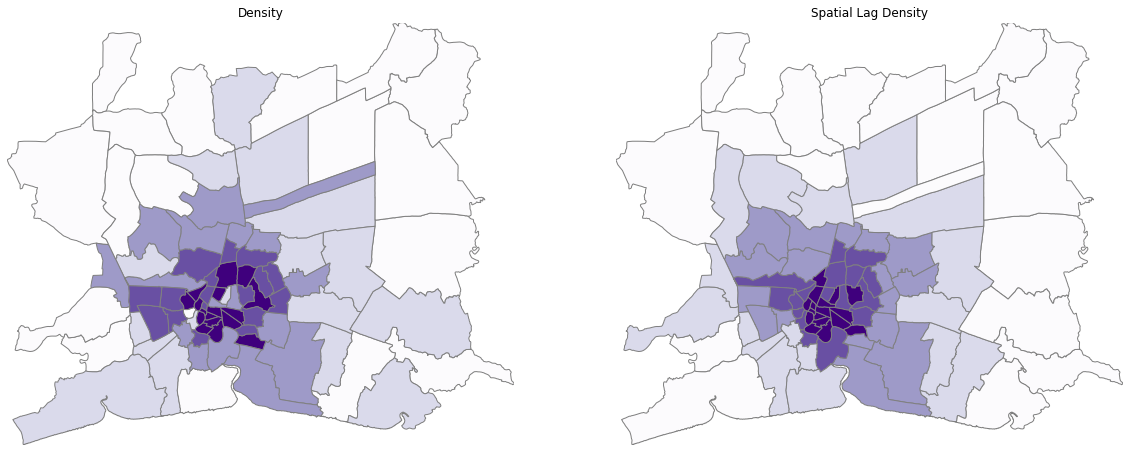

In [289]:
weighted_density_gdf['lag_density'] = ylag #make this _gdf
f,ax = plt.subplots(1,2,figsize=(20,10))

weighted_density_gdf.plot(column='density', ax=ax[0], edgecolor='grey',
        scheme="quantiles",  k=5, cmap='Purples')
ax[0].axis(weighted_density_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Density")

weighted_density_gdf.plot(column='lag_density', ax=ax[1], edgecolor='grey',
        scheme='quantiles', cmap='Purples', k=5)
ax[1].axis(weighted_density_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Density")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

Text(0.5, 0, "Moran's I")

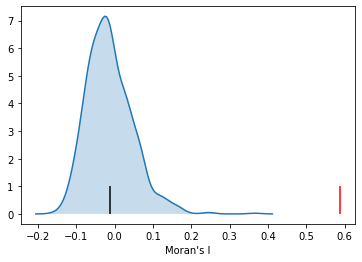

In [290]:
np.random.seed(123)
weighted_mi = esda.moran.Moran(weighted_y, weighted_wq) # Log?

sns.kdeplot(weighted_mi.sim, shade=True)
plt.vlines(weighted_mi.I, 0, 1, color='r')
plt.vlines(weighted_mi.EI, 0,1)
plt.xlabel("Moran's I")

In [291]:
# A p-value of 0.05 and less is significant
weighted_mi.p_sim # compared to value of ___ previously recorded for 3/8 of the districts

0.001

In [245]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.

## Local Autocorrelation

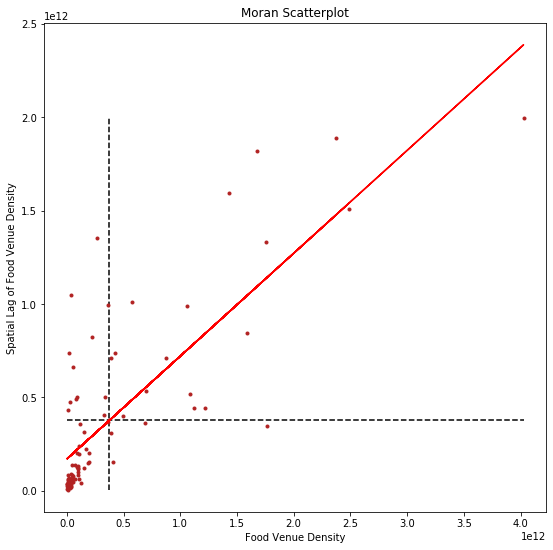

In [98]:
b, a = np.polyfit(y, ylag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(y, ylag, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(y.mean(), ylag.min(), ylag.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(ylag.mean(), y.min(), y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(y, a + b*y, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Food Venue Density')
plt.xlabel('Food Venue Density')
plt.show()

In [99]:
li = esda.moran.Moran_Local(y, wq)

In [100]:
# Determine number of statistically-significant hotspots/coldspots
(li.p_sim < 0.05).sum()

35

In [101]:
sig = 1 * (li.p_sim < 0.05)

hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)

spots = hotspot + coldspot + doughnut + diamond
spots

array([3, 3, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0, 0, 0, 1, 3, 0, 0, 3,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 1, 1, 3, 0, 3, 3, 3, 3, 0,
       0, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0,
       2, 0, 3, 3, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 0, 3, 1])

In [104]:
spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [112]:
venue_density_df.loc[:,'cluster_category'] = labels
venue_density_df.loc[:,'p_value'] = li.p_sim
venue_density_df.loc[:,'z_score'] = li.z_sim
venue_density_df.loc[:,'cluster_category'] = venue_density_df['cluster_category'].astype('category')
venue_density_df.head()

district                                           geometry    id  \
0          Ban Na  MULTIPOLYGON (((101.06481 14.41179, 101.06536 ...   299   
1         Ban Pho  MULTIPOLYGON (((100.96163 13.70401, 100.96242 ...   282   
2         Bang Bo  MULTIPOLYGON (((100.93635 13.66819, 100.93792 ...   307   
3        Bang Bon  MULTIPOLYGON (((100.43022 13.67181, 100.42820 ...   104   
4  Bang Bua Thong  MULTIPOLYGON (((100.38375 13.98669, 100.38609 ...  1094   

      area_sqkm       density cl   lag_density  p_value   z_score  \
0  2.951617e-08  1.013004e+10  0  5.594162e+09    0.001  0.994190   
1  1.733921e-08  1.626371e+10  0  2.907371e+10    0.043  0.935716   
2  1.827028e-08  1.680324e+10  1  5.289138e+10    0.019  1.318941   
3  3.017369e-09  3.446712e+10  1  8.653684e+10    0.079  1.209334   
4  1.106805e-08  9.884306e+10  2  1.156870e+11    0.209  0.876486   

    cluster_category  
0        3 cold spot  
1        3 cold spot  
2        3 cold spot  
3  0 not significant  
4  0 not significant

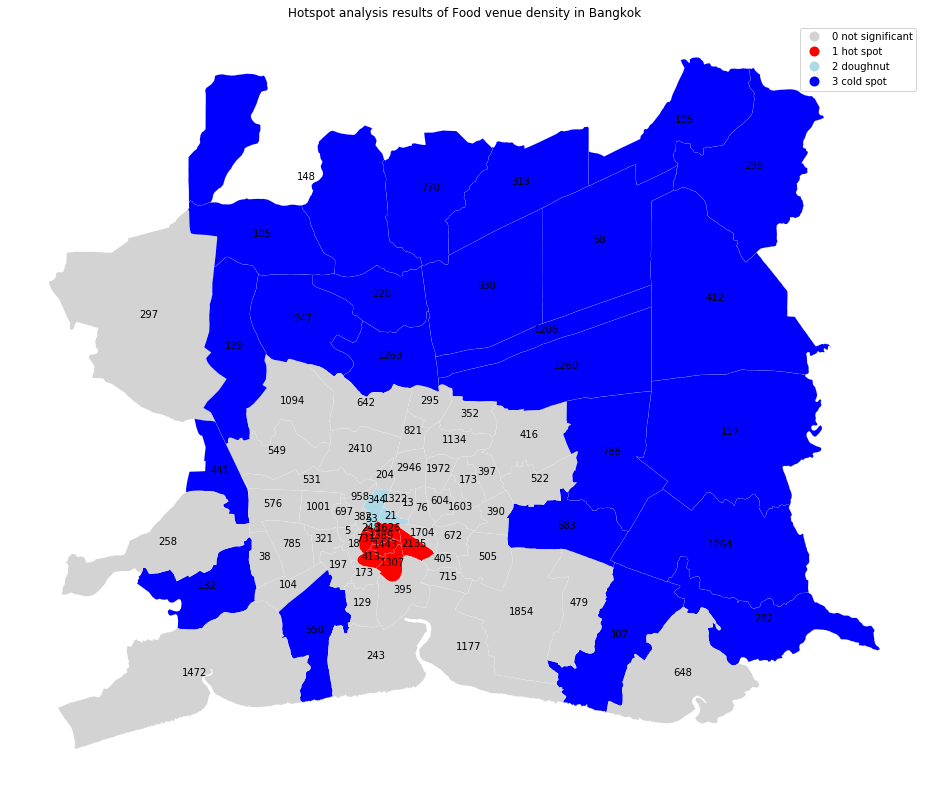

In [130]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds excluded with zero data points
f, ax = plt.subplots(1, figsize=(20, 14))

venue_density_df.plot(column='cluster_category', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

venue_density_df.apply(lambda x:\
                         ax.annotate(s=x.id, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plt.title('Hotspot analysis results of Food venue density in Bangkok')
plt.show()

In [113]:
# Print Doughnut neighbourhoods in order of significance
venue_density_df[venue_density_df.cluster_category=='2 doughnut'][['district', 'p_value']]\
    .sort_values('p_value')

district  p_value
62  Pom Pram Sattru    0.017
29            Dusit    0.020
66      Ratchathewi    0.027

In [ ]:
# Moran's I identifies 3 statistically-significant regions as opportunities for food delivery services.

## Weighted Local Autocorrelation

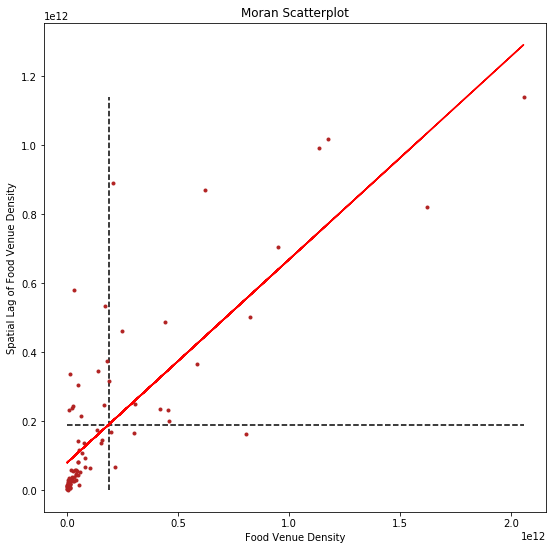

In [292]:
b, a = np.polyfit(weighted_y, weighted_ylag, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(weighted_y, weighted_ylag, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(weighted_y.mean(), weighted_ylag.min(), weighted_ylag.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(weighted_ylag.mean(), weighted_y.min(), weighted_y.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(weighted_y, a + b*weighted_y, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Food Venue Density')
plt.xlabel('Food Venue Density')
plt.show()

In [293]:
weighted_li = esda.moran.Moran_Local(weighted_y, weighted_wq)

In [294]:
# Determine number of statistically-significant hotspots/coldspots
(weighted_li.p_sim < 0.05).sum()

36

In [295]:
sig = 1 * (weighted_li.p_sim < 0.05)

hotspot = 1 * (sig * weighted_li.q==1)
coldspot = 3 * (sig * weighted_li.q==3)
doughnut = 2 * (sig * weighted_li.q==2)
diamond = 4 * (sig * weighted_li.q==4)

weighted_spots = hotspot + coldspot + doughnut + diamond
weighted_spots

array([3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 1, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 1, 1, 3, 0, 3, 3, 3, 3, 0,
       0, 3, 0, 3, 0, 0, 3, 3, 0, 3, 0, 1, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0,
       2, 0, 3, 3, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 3, 0, 1, 3, 1])

In [296]:
spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [297]:
weighted_density_gdf.loc[:,'cluster_category'] = labels
weighted_density_gdf.loc[:,'p_value'] = weighted_li.p_sim
weighted_density_gdf.loc[:,'z_score'] = weighted_li.z_sim
weighted_density_gdf.loc[:,'cluster_category'] = weighted_density_gdf['cluster_category'].astype('category')
weighted_density_gdf.head()

district                                           geometry  \
0          Ban Na  MULTIPOLYGON (((101.06481 14.41179, 101.06536 ...   
1         Ban Pho  MULTIPOLYGON (((100.96163 13.70401, 100.96242 ...   
2         Bang Bo  MULTIPOLYGON (((100.93635 13.66819, 100.93792 ...   
3        Bang Bon  MULTIPOLYGON (((100.43022 13.67181, 100.42820 ...   
4  Bang Bua Thong  MULTIPOLYGON (((100.38375 13.98669, 100.38609 ...   

   venue_value_weight     area_sqkm       density cl   lag_density  \
0              108.50  2.951617e-08  3.675951e+09  0  5.594162e+09   
1              107.00  1.733921e-08  6.170984e+09  0  2.907371e+10   
2              116.50  1.827028e-08  6.376475e+09  1  5.289138e+10   
3               65.75  3.017369e-09  2.179051e+10  1  8.653684e+10   
4              451.50  1.106805e-08  4.079309e+10  2  1.156870e+11   

    cluster_category  p_value   z_score  
0        3 cold spot    0.001  0.930944  
1        3 cold spot    0.030  0.897553  
2        3 cold spot    0.010  1.283561  
3  0 not significant    0.067  1.174378  
4  0 not significant    0.160  0.886605

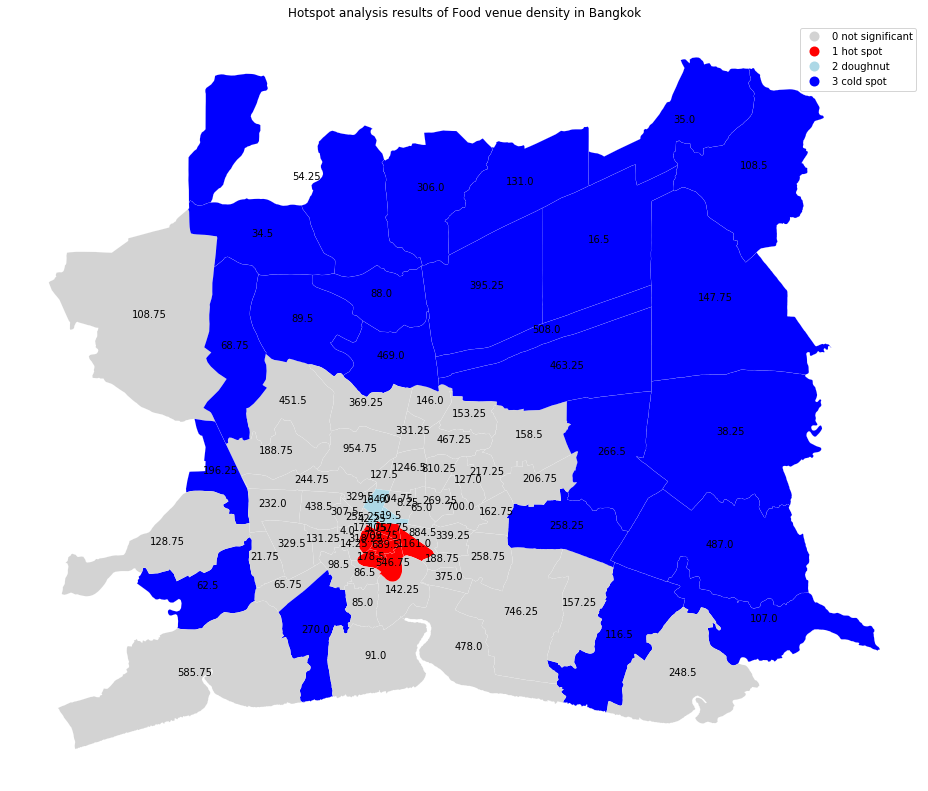

In [299]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds excluded with zero data points
f, ax = plt.subplots(1, figsize=(20, 14))

weighted_density_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

weighted_density_gdf.apply(lambda x:\
                         ax.annotate(s=x.venue_value_weight, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plt.title('Hotspot analysis results of Food venue density in Bangkok')
plt.show()

In [300]:
# Print Doughnut neighbourhoods in order of significance
weighted_density_gdf[weighted_density_gdf.cluster_category=='2 doughnut'][['district', 'p_value']]\
    .sort_values('p_value')

district  p_value
62  Pom Pram Sattru    0.003
29            Dusit    0.017
66      Ratchathewi    0.024

In [304]:
# Print Hot Spot neighbourhoods in order of significance
weighted_density_gdf[weighted_density_gdf.cluster_category=='1 hot spot'][['district', 'p_value']]\
    .sort_values('p_value')

district  p_value
17       Bang Rak    0.001
35     Khlong San    0.001
55     Pathum Wan    0.001
71  Samphantawong    0.001
73        Sathorn    0.001
36    Khlong Toey    0.006
84        Yannawa    0.039
8   Bang Kho Laem    0.074

In [305]:
# Print Cold Spot neighbourhoods in order of significance
weighted_density_gdf[weighted_density_gdf.cluster_category=='3 cold spot'][['district', 'p_value']]\
    .sort_values('p_value')

district  p_value
0               Ban Na    0.001
40       Lat Bua Luang    0.001
83         Wihan Daeng    0.003
45  Muang Chachoengsao    0.004
33        Khlong Luang    0.007
51            Nong Sua    0.008
69            Sam Khok    0.009
68             Sai Noi    0.009
80            Wang Noi    0.010
2              Bang Bo    0.010
18            Bang Sai    0.015
50           Nong Chok    0.015
37        Krathum Baen    0.016
12      Bang Nam Prieo    0.017
13          Bang Pa-In    0.018
39          Lam Luk Ka    0.020
76          Thanyaburi    0.020
53           Ongkharak    0.023
47  Muang Pathum Thani    0.026
61    Phuttha Mon Thon    0.027
42        Lat Lum Kaeo    0.027
41         Lat Krabang    0.029
1              Ban Pho    0.030
21        Bangkhuntien    0.052

In [ ]:
# Moran's I identifies 3 statistically-significant regions as opportunities for food delivery services.